In [1]:
# Auto reload function (if modified outside notebook)
%load_ext autoreload
%autoreload 2
# Plot precision
%config InlineBackend.figure_format ='retina'
# Interactive cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import pydot
from scipy import stats

from decision_tree import *

# <div align="center"> Report : cloud detection - method analysis </div>

<div align="right">Alexandre Bort </div>

# <div align="right"><small>17/06/2019 <small> </div>
    



### Note:
This notebook does not emphasize on the code itself, but the output collected from the different process. If you want more code details, please refer to the `decision_tree.py` [file](https://github.com/alexandreb09/Sentinel-Cloud-Masking/blob/master/Upload_Data/decision_tree.py) and for the whole project to this [GitHub repo.](https://github.com/alexandreb09/Sentinel-Cloud-Masking)

## Plan
```
 I. Context
 II. Current situation
 III. Methods
      III.A. Random Forest
            1. Number of estimators
            2. Tree overview
            3. Features importance
      III.B. Others
            1. Decision tree
            2. Logistic regression
 IV. Results
```
---

## I. Context
 - **Initial goal** : label pixels in cloud or not cloud pixels.
 - **How**: 13 different methods (10 based on difference between the image and a non cloud image reference - 3 ready to use decision trees). 
 - **Dataset** : public labelled dataset ([repo](https://gitext.gfz-potsdam.de/EnMAP/sentinel2_manual_classification_clouds)) answering the question if a pixel is a cloud or not.
 - **Goal of the report**: build a robust cloud detection model based on our set of methods
 
## II. Current situation

 - **Methods processing**: the main bugs present in our methods have been fixed 
   - Non-square image: 
      - all the image haven't the same shape -according to the satellite path)
      - solved by adding a common area criteria
   - Duplicated images: 
      - some images have been sampled at the same date, but provided at different dates. As a result, there are duplicate images with different ids
      - solved by filtering the sample date and distribution date
   - Full mask bands: 
      - some extra bands are always empty (QA10 - QA20)
      - solved by ignoring those problematic bands
<br/><br/>
 - After processing all those images, the methods still fail on some pixels. That leads us to remove:
    - 3036 pixels from the 200 000 as input (1.5%) on the Training set 
    - 924 pixels from the 60 000 as input (1.5%) on the Evaluation dataset
  
  => The final training (respectively evaluation) dataset is composed by 196964 (resp. 59076) samples (pixels).
   
The dataset looks like this:

In [2]:
# Load module
import pandas as pd
# Load training - evaluation dataset
training = pd.read_excel("Data/results.xlsx", sheet_name="Training")
evaluation = pd.read_excel("Data/results.xlsx", sheet_name="Evaluation")

# Creating feature - output dataset
x_train, y_train = split_feature_output(training, show_time= False)
x_test, y_test = split_feature_output(evaluation, show_time=False)

# Create whole dataset
data = training.append(evaluation)
data.head()

,cloud,id_GEE,index,latitude,longitude,percentile1,percentile2,percentile3,percentile4,percentile5,persistence1,persistence2,persistence3,persistence4,persistence5,tree1,tree2,tree3
0,1,COPERNICUS/S2/20151203T105422_20151203T105811_...,0,38.065710,-0.786016,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,COPERNICUS/S2/20151203T105422_20151203T105811_...,1,38.349942,-1.563068,0,0,0,0,0,0,1,0,1,0,0,0,0
2,0,COPERNICUS/S2/20151203T105422_20151203T105811_...,2,37.994208,-1.775253,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0,COPERNICUS/S2/20151203T105422_20151203T105811_...,3,38.725824,-0.892539,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0,COPERNICUS/S2/20151203T105422_20151203T105811_...,4,38.025237,-0.878142,0,0,0,0,0,0,1,0,1,0,0,0,0


Let's see the repartition of the different columns:

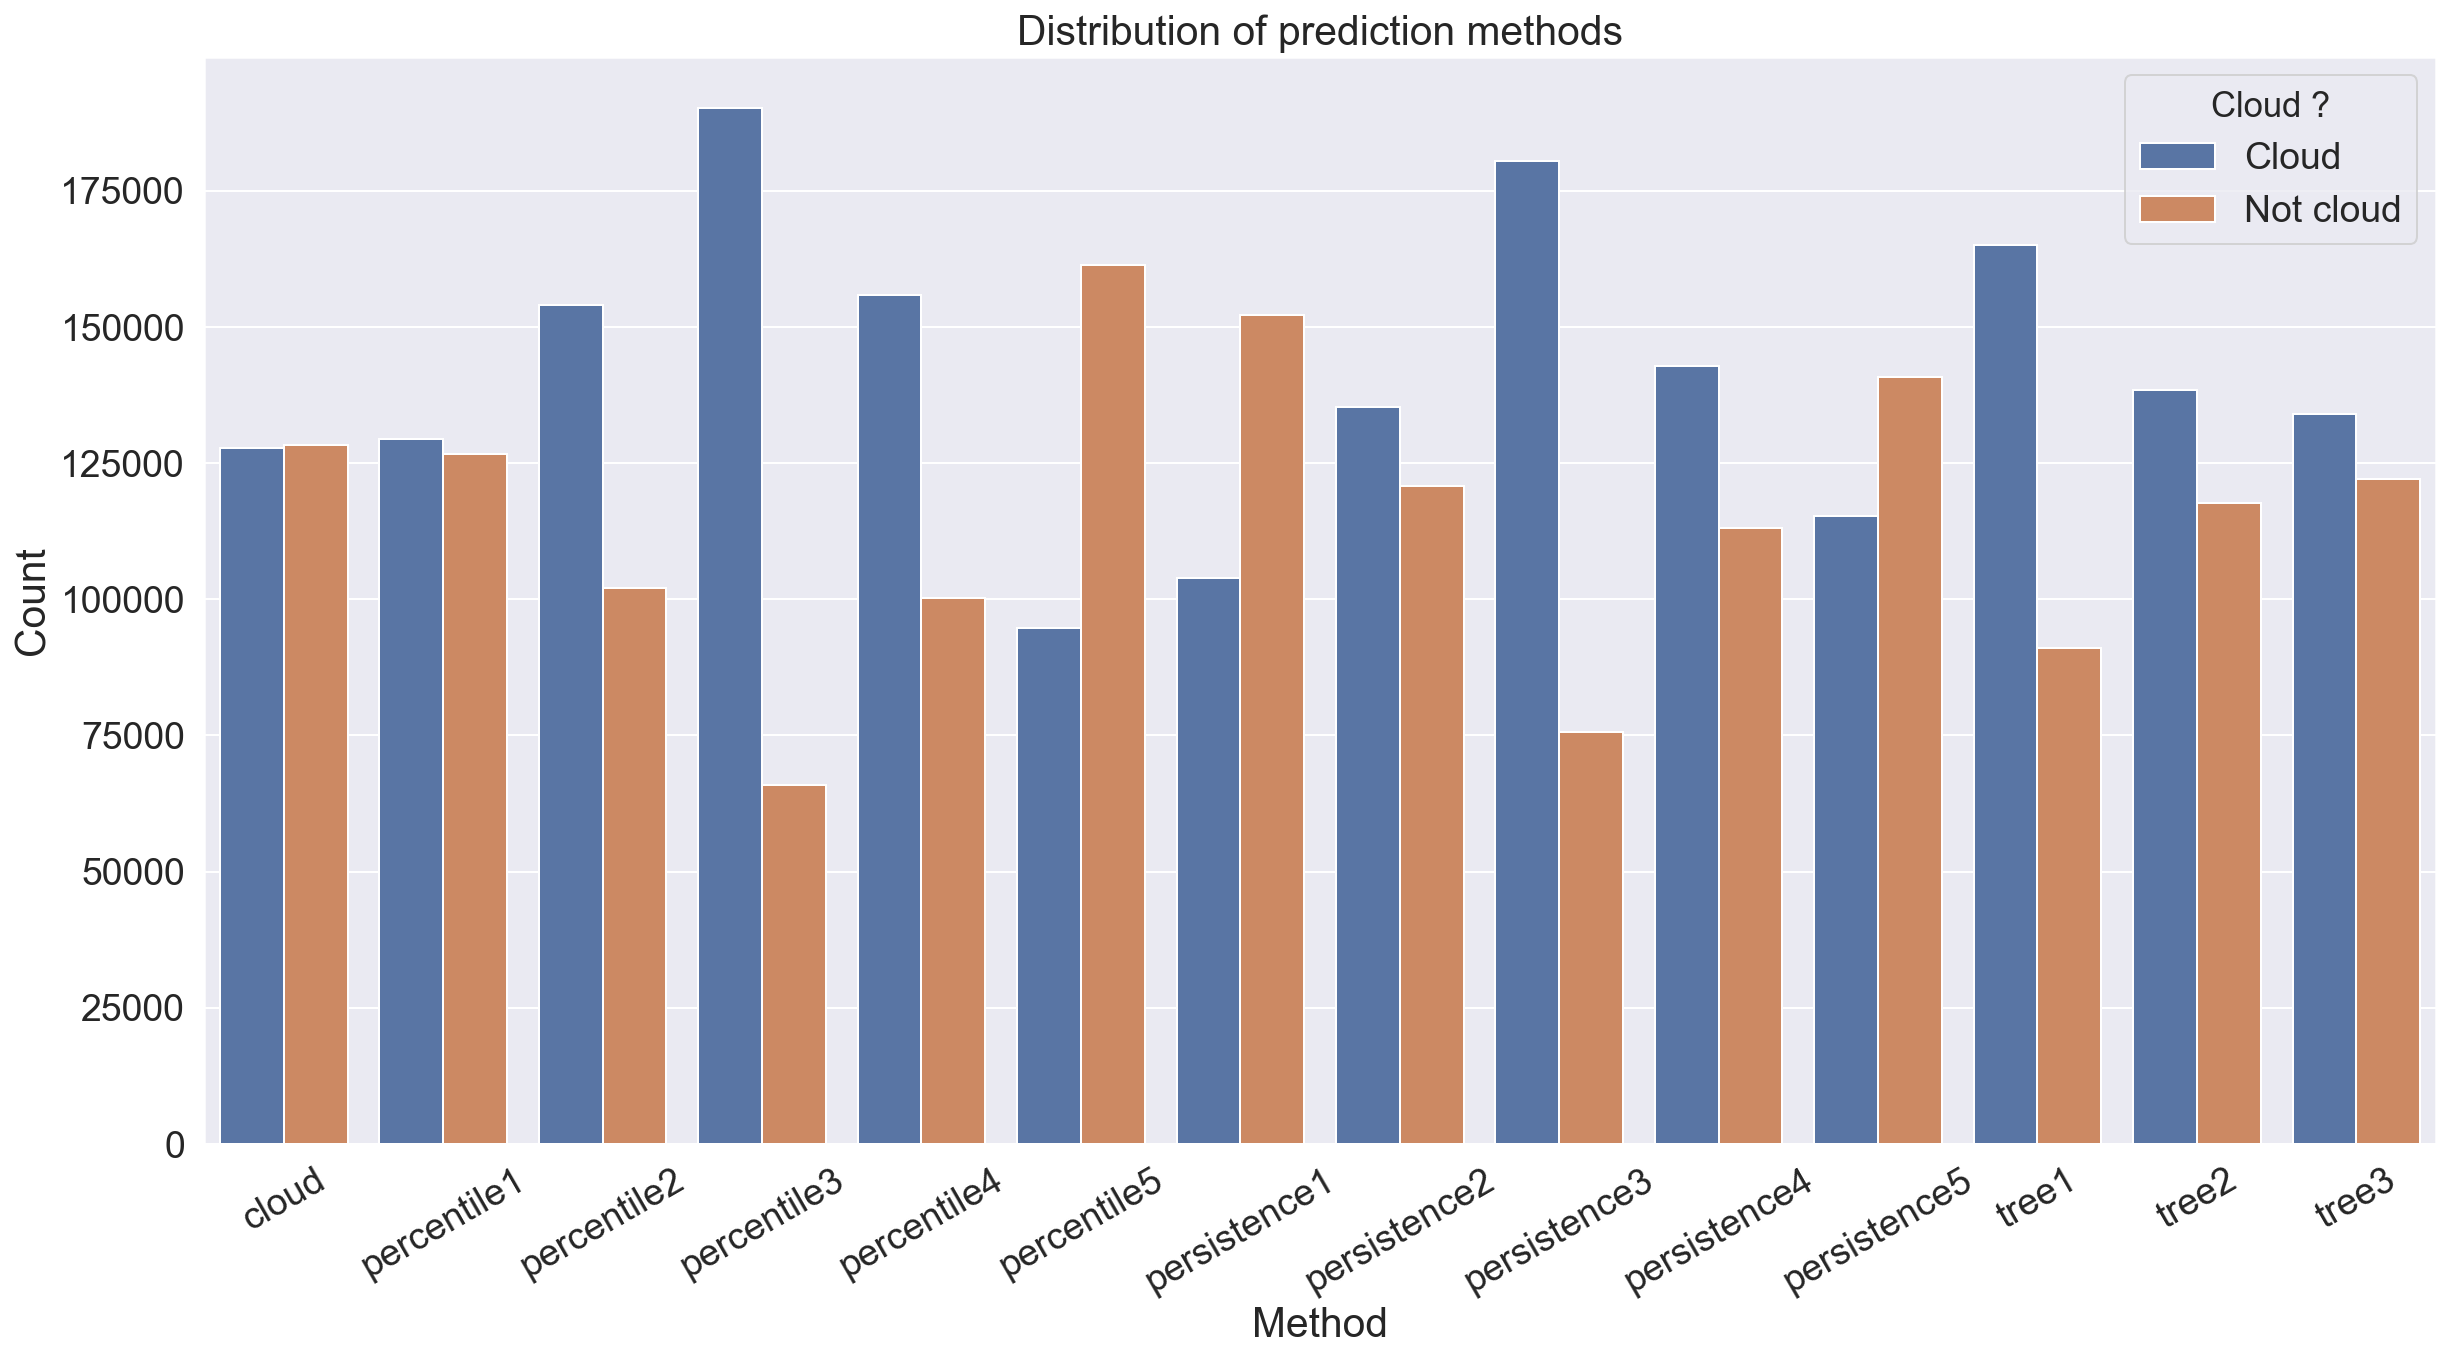

In [3]:
# Plot the repartition of cloud - Not cloud pixels per methods
plot_methods_repartition(data)

**Correlation**
 - The correlation matrix doesn't show a high correlation between the methods. Only the 3 `tree` methods have a high one. 
 - If all methods are perfect, we expect to have a complete correlation. However, this is not the case, so we can build a model based on all those methods. The 3 `tree` methods are the column with the highest correlation to `cloud` column, meaning they are accurate methods.

Note: having a full correlation doesn't mean the methods are accurate (all can't predict the same wrong output).  

In [4]:
# Plot size
plt.figure(figsize=(20,10)) 

data[["cloud"] + feature_names].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

<Figure size 1440x720 with 0 Axes>

,cloud,percentile1,percentile2,percentile3,percentile4,percentile5,persistence1,persistence2,persistence3,persistence4,persistence5,tree1,tree2,tree3
cloud,1,0.55,0.49,0.27,0.49,0.6,0.38,0.41,0.32,0.42,0.49,0.71,0.87,0.89
percentile1,0.55,1,0.78,0.56,0.77,0.69,0.59,0.57,0.6,0.61,0.62,0.58,0.53,0.54
percentile2,0.49,0.78,1,0.67,0.84,0.61,0.5,0.61,0.66,0.62,0.59,0.61,0.53,0.51
percentile3,0.27,0.56,0.67,1,0.68,0.43,0.39,0.48,0.69,0.49,0.45,0.39,0.32,0.28
percentile4,0.49,0.77,0.84,0.68,1,0.59,0.51,0.58,0.68,0.65,0.63,0.58,0.53,0.5
percentile5,0.6,0.69,0.61,0.43,0.59,1,0.56,0.51,0.47,0.49,0.63,0.52,0.55,0.59
persistence1,0.38,0.59,0.5,0.39,0.51,0.56,1,0.61,0.45,0.54,0.49,0.38,0.36,0.36
persistence2,0.41,0.57,0.61,0.48,0.58,0.51,0.61,1,0.51,0.66,0.53,0.47,0.42,0.41
persistence3,0.32,0.6,0.66,0.69,0.68,0.47,0.45,0.51,1,0.53,0.47,0.45,0.35,0.33
persistence4,0.42,0.61,0.62,0.49,0.65,0.49,0.54,0.66,0.53,1,0.52,0.44,0.44,0.43


<Figure size 1440x720 with 0 Axes>

# III. Methods

##  III.A. Random Forest

### 1. Number of estimatros
I used the `randomForestClassifier` method from the `sklearn` package [(doc)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). A lot of options are available. One important option is **the number of samples** used for building the randomForest model: `n_estimators`. Obviously, the bigger it is, the better the results are. However, using a lot of estimators is resource consuming. 

The following figure has 2 plots:
 - <span style="text-decoration:underline">Plot 1</span>: accuracy over the number of estimators
 - <span style="text-decoration:underline">Plot 2</span>: time processing over the number of estimators 

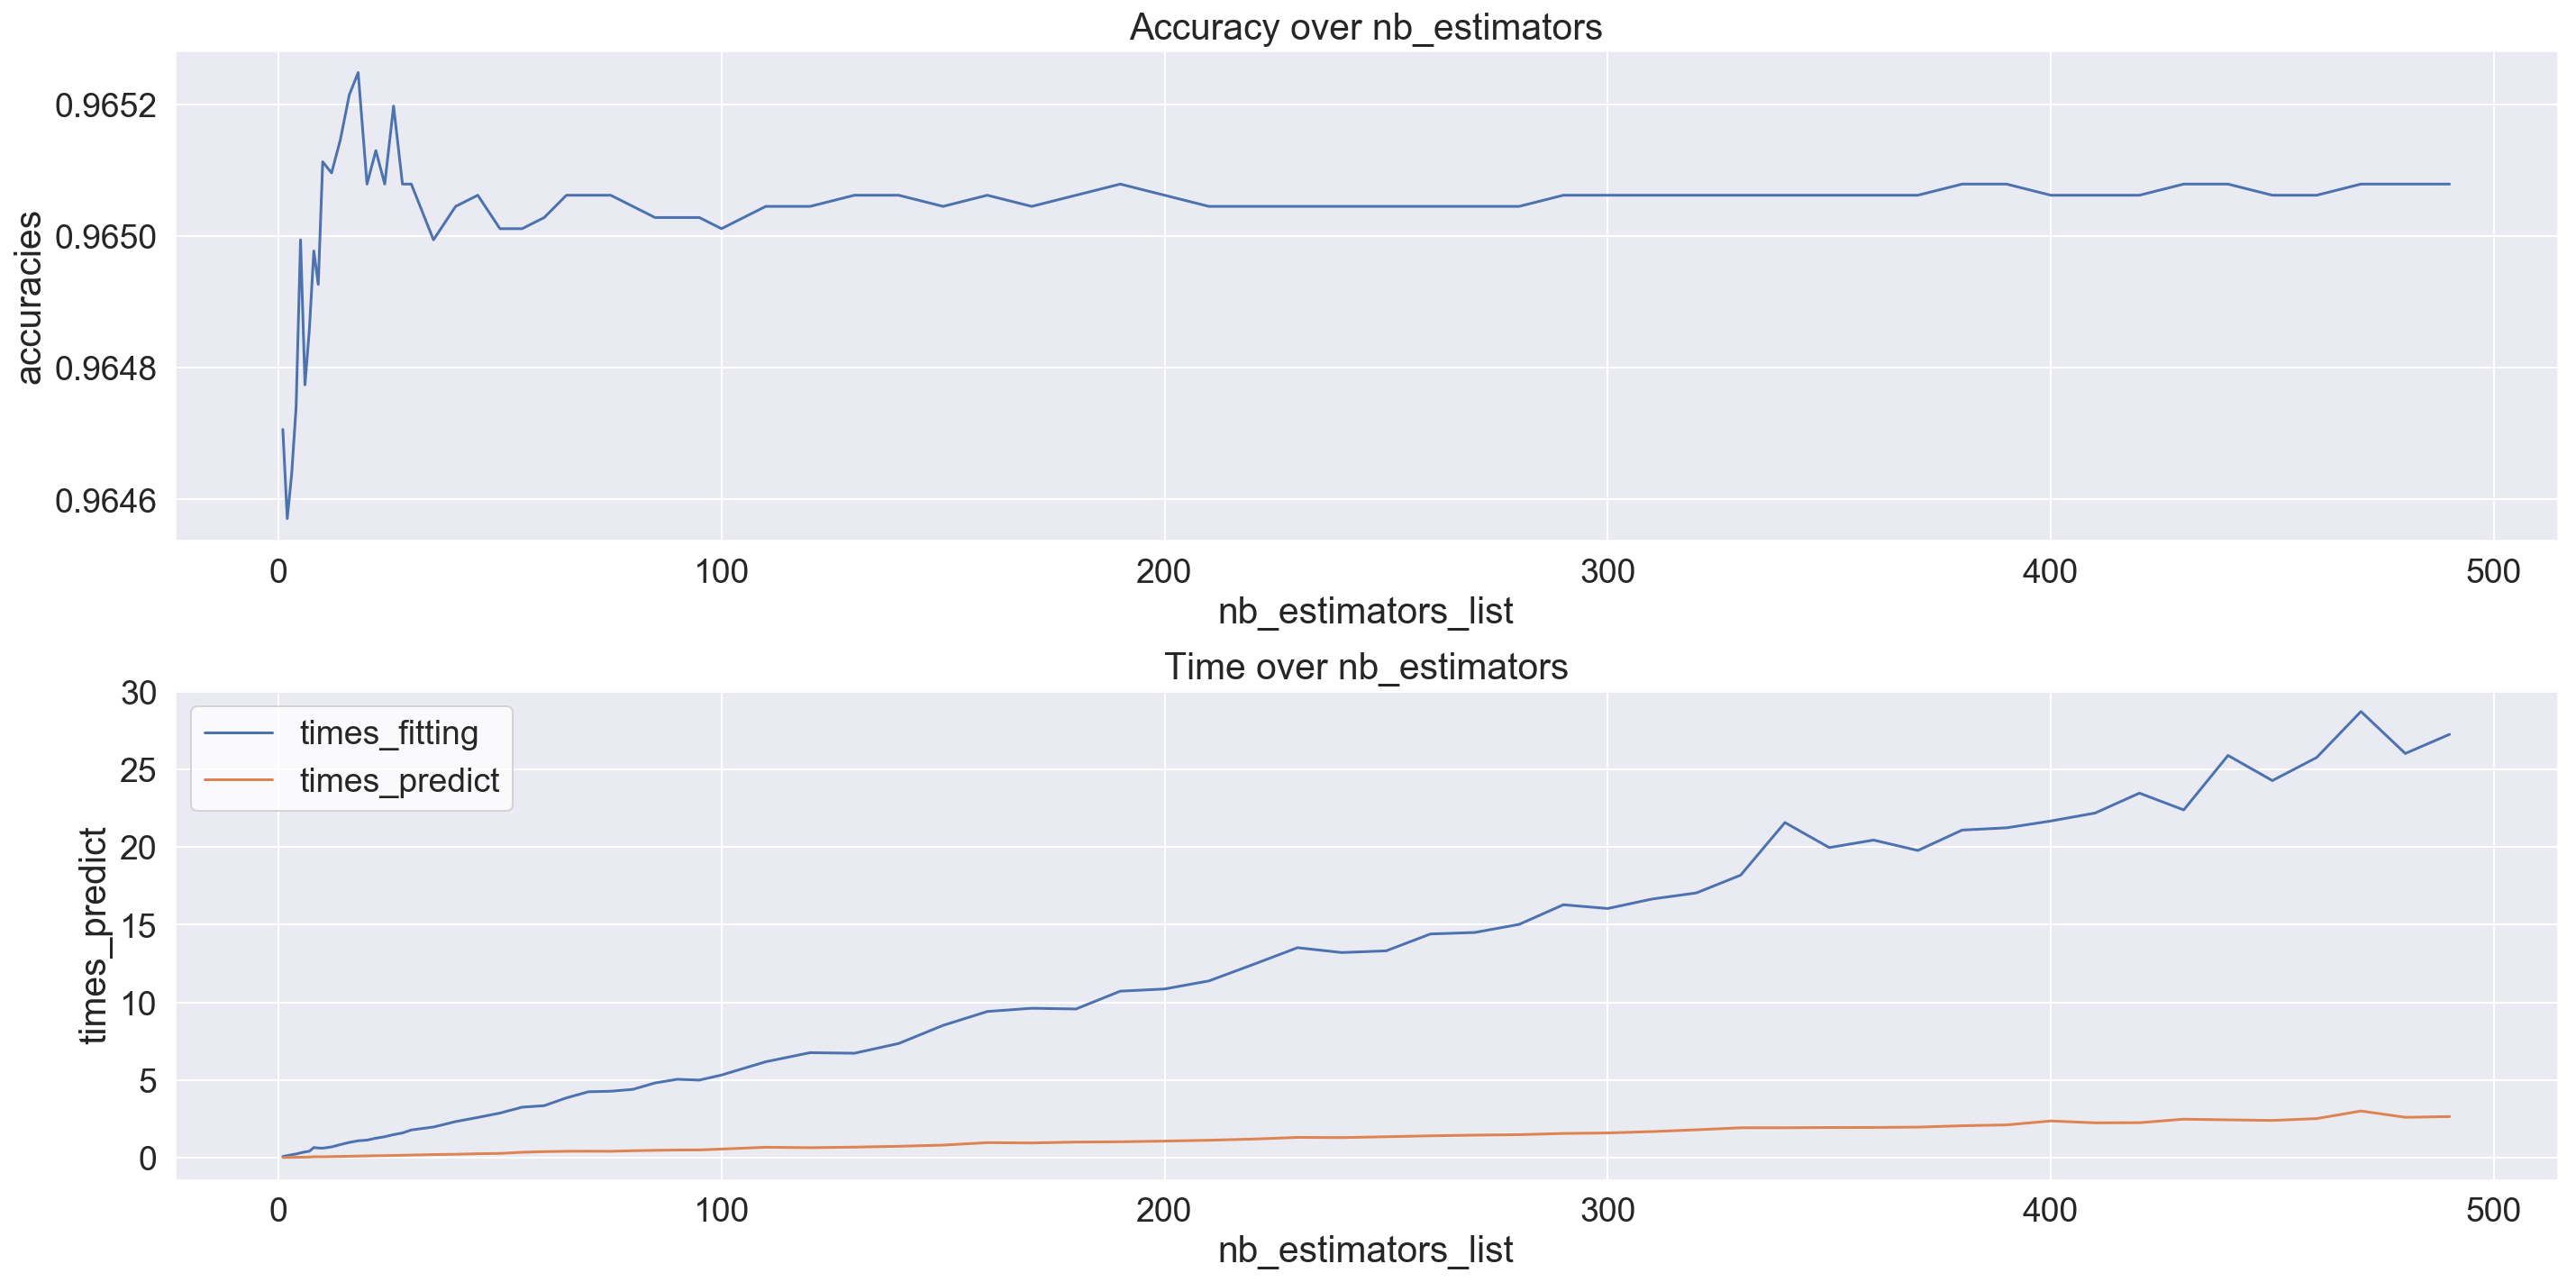

In [5]:
res_rand_forest = compute_accuracy_over_nb_estimators(x_train, x_test, y_train, y_test, show_plot=True, progress_bar=False)

Strangely enough, the best accuracy is for a small number of estinators. However, these variations are very little (occur after the 3rd digit). The first fluctuation could be understood as noise. This noise is reduced when the number of estimators increases. 

In [6]:
print("20 best accuracies (sorted):\n", res_rand_forest.sort_values(by="accuracies", ascending=False).head(20))

20 best accuracies (sorted):
     nb_estimators_list  accuracies  times_fitting  times_predict
13                  18    0.965248       1.089392       0.103943
12                  16    0.965214       0.983454       0.094948
17                  26    0.965197       1.487180       0.144901
11                  14    0.965147       0.845549       0.080938
15                  22    0.965130       1.255308       0.127929
9                   10    0.965113       0.613658       0.059955
10                  12    0.965096       0.693616       0.071941
72                 490    0.965079      27.256369       2.648493
14                  20    0.965079       1.132390       0.114919
42                 190    0.965079      10.720836       1.025624
61                 380    0.965079      21.092821       2.057639
62                 390    0.965079      21.236694       2.111400
19                  30    0.965079       1.785028       0.168888
16                  24    0.965079       1.351233       0.13

In the rest of the report, we will **assume** that : **`n_estimators=500`.** Here the model:

In [7]:
## Create Random forest model
# Next results assumes n_estimators = 500
nb_estimators = 500

# Create result dataframe + compute feature accuracy
res_accuracy = pd.DataFrame({"Methods": feature_names,
                             "Accuracy": [accuracy_score(data.cloud, data[col]) for col in feature_names]})

# Create Decision Tree classifer object
model_rf = RandomForestClassifier(n_estimators=nb_estimators, random_state=0)
# Fit model
model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### III.A.2. Tree overview
The depths of the trees in the random forest model (for 500 estimators) are the following:

In [8]:
# Predict the response for test dataset
y_pred = model_rf.predict(x_test)

# Add the accuracy to the accuracy results
add_row(res_accuracy, ["randomForest", accuracy_score(y_test, y_pred)])

# Save the first tree of the forest as a png image
export_graphviz(model_rf.estimators_[0], out_file='tree_rf.dot',
                feature_names=list(training.columns[5:]),
                class_names=["Not Cloudy", "Cloudy"],
                rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree_rf.dot')
graph.write_png('tree_rf.png')


lengths = np.array([estimator.tree_.max_depth for estimator in model_rf.estimators_])

print("Length statistics of the trees in the randomForest model (n_estimatros=%d):" % (nb_estimators))
print("\t- Min: %3d\n\t- Max: %3d\n\t- Mean: %3.2f" % (min(lengths), max(lengths), sum(lengths)/len(lengths)))

nodes = np.array([estimator.tree_.node_count for estimator in model_rf.estimators_])

print("\nNodes count statistics of the trees in the randomForest model (n_estimatros=%d):" % (nb_estimators))
print("\t- Min: %3d\n\t- Max: %3d\n\t- Mean: %3.2f" % (min(nodes), max(nodes), sum(nodes)/len(nodes)))

,Methods,Accuracy
0,randomForest,0.965079
1,percentile1,0.775145
2,percentile2,0.740978
3,percentile3,0.617571
4,percentile4,0.737553
5,percentile5,0.790466
6,persistence1,0.685592
7,persistence2,0.705503
8,persistence3,0.645212
9,persistence4,0.708464


Length statistics of the trees in the randomForest model (n_estimatros=500):
	- Min:  13
	- Max:  13
	- Mean: 13.00

Nodes count statistics of the trees in the randomForest model (n_estimatros=500):
	- Min: 1493
	- Max: 1727
	- Mean: 1589.74


The first tree of the decision tree looks like this:
![First tree of the decision tree model](tree_rf.png)

### III.A.3. Features importance

The following graph shows the **importance per feature**. The 3 `tree` methods are the most important. This is consistent with the correlation matrix saw in section II.

[Text(0, 0, 'tree3'),
 Text(0, 0, 'tree2'),
 Text(0, 0, 'tree1'),
 Text(0, 0, 'percentile5'),
 Text(0, 0, 'percentile1'),
 Text(0, 0, 'percentile2'),
 Text(0, 0, 'persistence5'),
 Text(0, 0, 'percentile4'),
 Text(0, 0, 'persistence2'),
 Text(0, 0, 'persistence4'),
 Text(0, 0, 'persistence1'),
 Text(0, 0, 'persistence3'),
 Text(0, 0, 'percentile3')]

Text(0.5, 1.0, 'Importance per feature (Random forest model)')

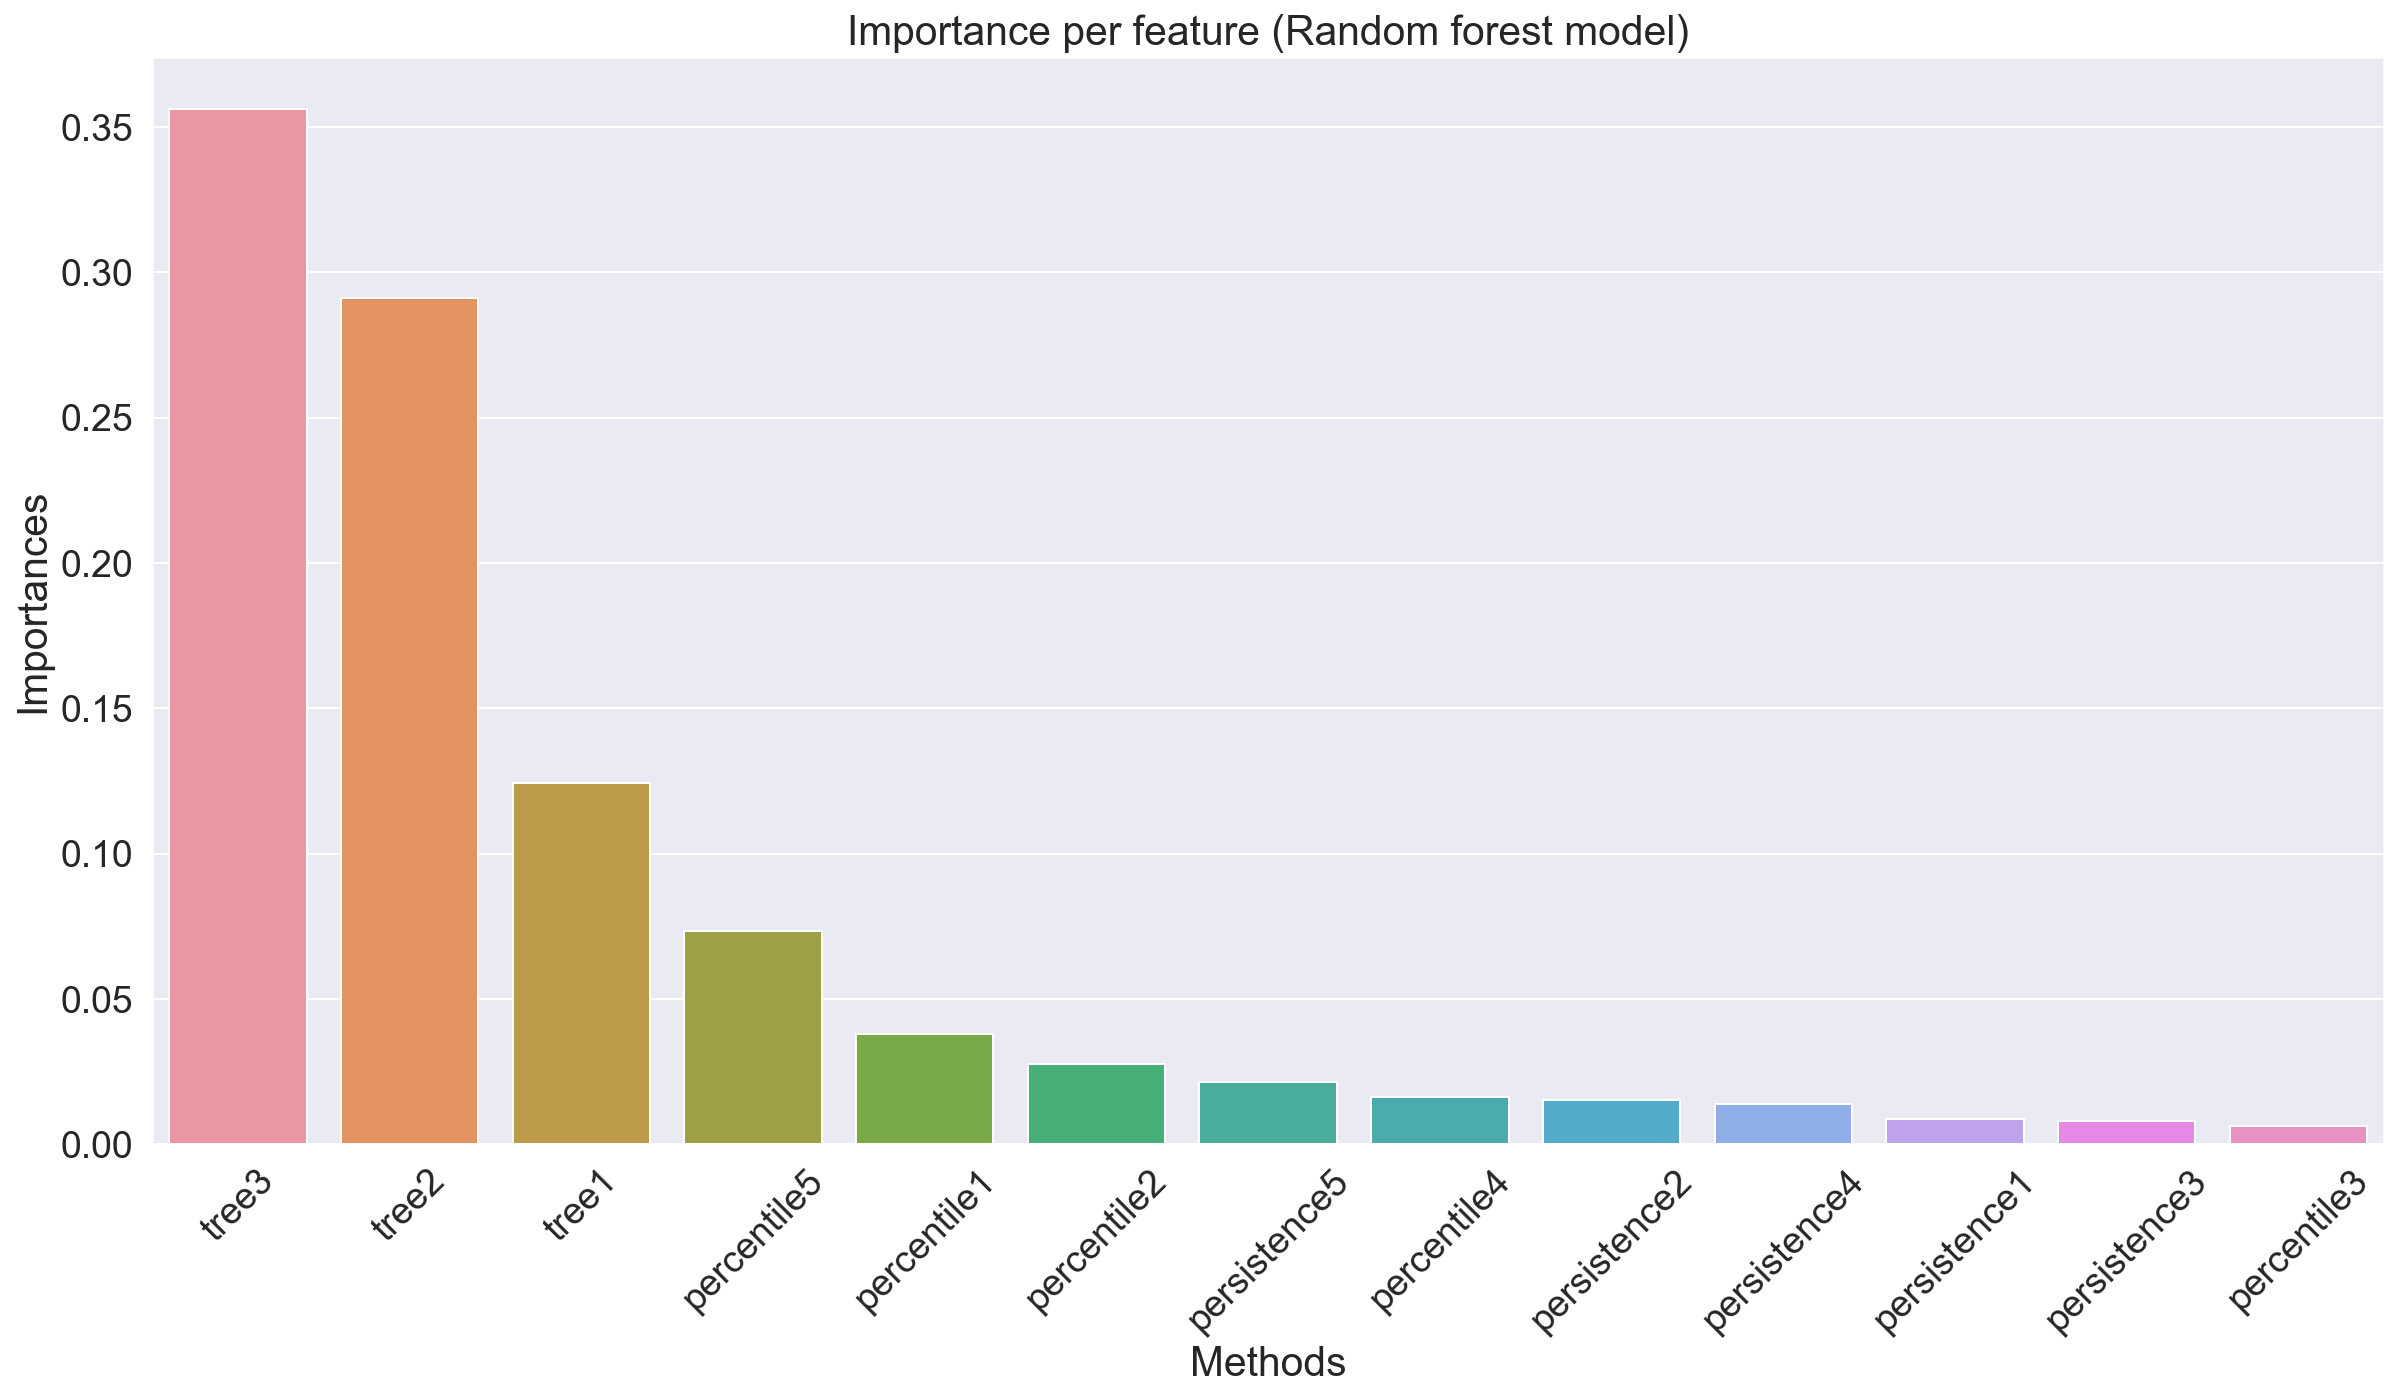

In [9]:
tmp = pd.DataFrame({"Methods": feature_names, 
              "Importances": model_rf.feature_importances_}).sort_values(by="Importances", ascending=False)
g = sns.barplot(x='Methods', y='Importances', data=tmp, )
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title("Importance per feature (Random forest model)")
plt.show()

The following graph shows the **accuracy** when the number of features used in the random forest decreases. Between each iteration is removed the feature having the smallest importance.

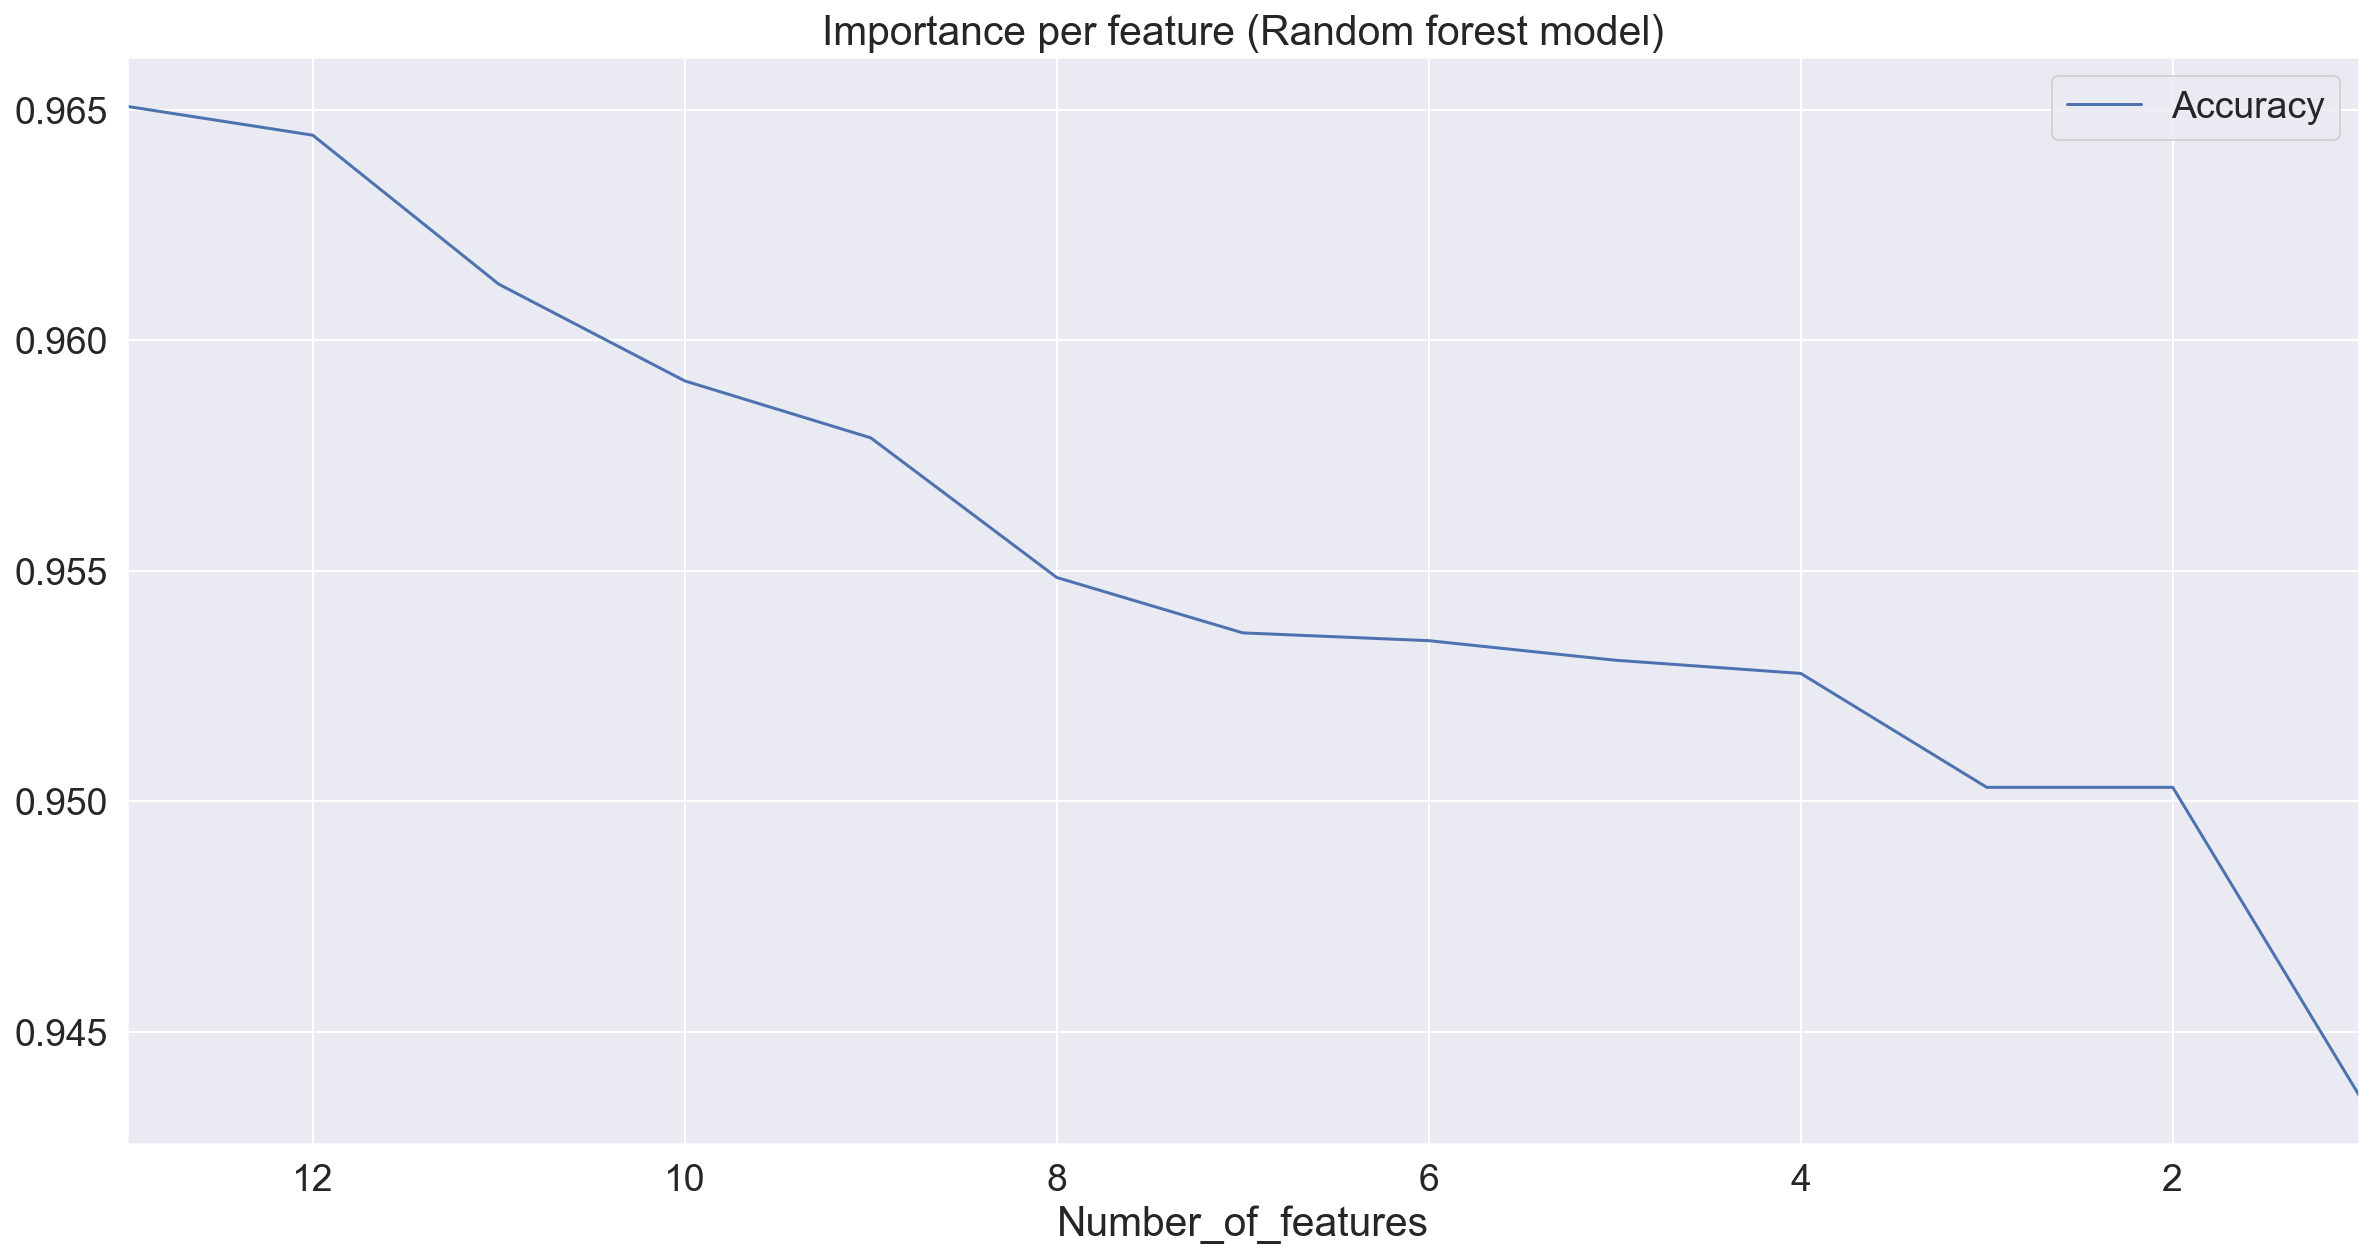

In [10]:
accuracy_over_nb_estimatros = accuracy_over_number_of_feature(training, evaluation, nb_estimators)
accuracy_over_nb_estimatros \
            .plot('Number_of_features', 'Accuracy', rot=0, title="Importance per feature (Random forest model)") \
            .invert_xaxis()

## III.B. Others methods
I have also tried to build two other models: a **logistic regression model** and a **decision tree** model.

### 1. Decision tree
I used the `DecisionTreeClassifier` method from the `sklearn` package to build the decision tree model. The tree is similar to the one built in the random forest model.
The decision tree is also deep:  

In [11]:
# Create Decision Tree classifer object
tree = DecisionTreeClassifier()
# Train Decision Tree Classifer
tree = tree.fit(x_train, y_train)
# Predict the response for test dataset
y_pred = tree.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
add_row(res_accuracy, ["decisionTree", accuracy])

# Save the tree as a png image
export_graphviz(model_rf.estimators_[0], out_file='decision_tree.dot',
                feature_names=list(training.columns[5:]),
                class_names=["Not Cloudy", "Cloudy"],
                rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('decision_tree.dot')
graph.write_png('decision_tree.png')

print("Tree depth: ", tree.tree_.max_depth)
print("Number of node: ", tree.tree_.node_count)

,Methods,Accuracy
0,decisionTree,0.964960
1,randomForest,0.965079
2,percentile1,0.775145
3,percentile2,0.740978
4,percentile3,0.617571
5,percentile4,0.737553
6,percentile5,0.790466
7,persistence1,0.685592
8,persistence2,0.705503
9,persistence3,0.645212


Tree depth:  13
Number of node:  1649


The tree is similar to the ones from the random forest model:
    ![decision tree](decision_tree.png)

[Text(0, 0, 'tree3'),
 Text(0, 0, 'tree2'),
 Text(0, 0, 'percentile5'),
 Text(0, 0, 'percentile3'),
 Text(0, 0, 'persistence4'),
 Text(0, 0, 'persistence3'),
 Text(0, 0, 'persistence2'),
 Text(0, 0, 'persistence1'),
 Text(0, 0, 'persistence5'),
 Text(0, 0, 'percentile1'),
 Text(0, 0, 'percentile2'),
 Text(0, 0, 'percentile4'),
 Text(0, 0, 'tree1')]

Text(0.5, 1.0, 'Feature importance decision tree')

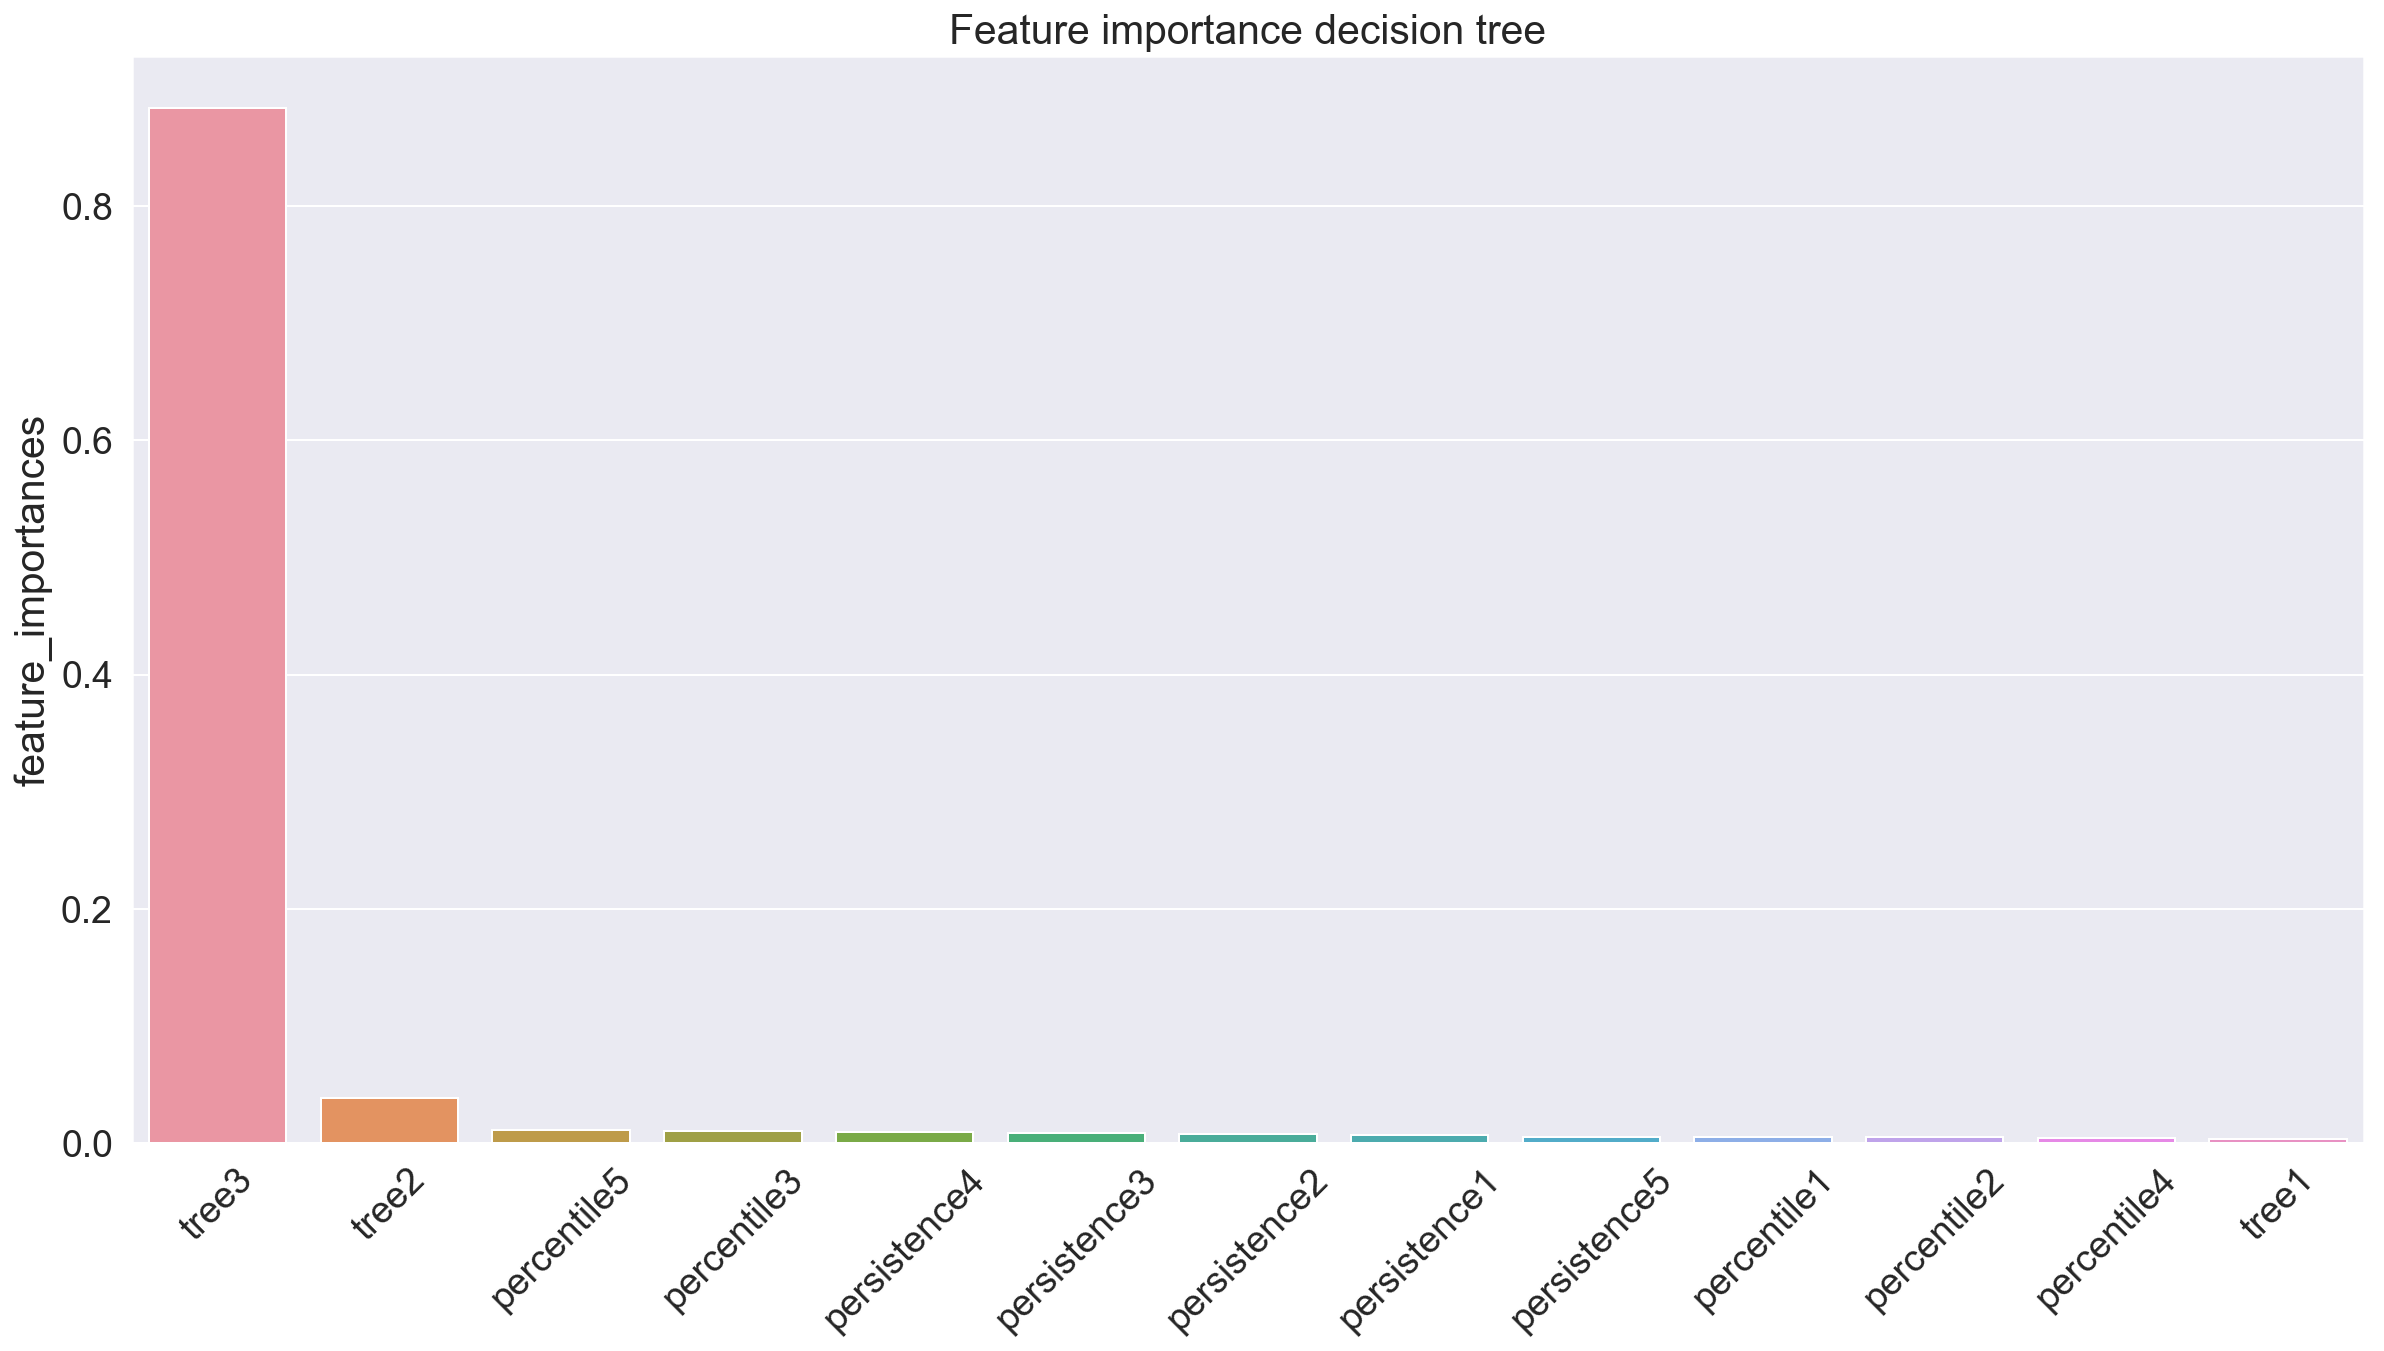

In [12]:

tmp = dict(zip(feature_names, tree.feature_importances_))
tmp = {key:[value] for key, value in tmp.items()}
tmp = pd.DataFrame(tmp).T
tmp.columns = ["feature_importances"]
tmp = tmp.sort_values(by="feature_importances", ascending=False)
g = sns.barplot(x = tmp.index , y="feature_importances", data=tmp)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title("Feature importance decision tree")
plt.show()

### III.B.2. Logistic regression
I use the `LogisticRegression` function from `sklearn` package. The model output is a score between `0` and `1`. Then, I classify the output by comparing them to `0.5`.

In [13]:
from sklearn.linear_model import LogisticRegression
# Create model
model = LogisticRegression(solver='liblinear')
# Fit model
model.fit(x_train, y_train)
# Predict the response for test dataset (proba output)
y_pred = model.predict(x_test)
# Categorize the output
y_pred = np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
add_row(res_accuracy, ["logisticRegression", accuracy])
pass

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

,Methods,Accuracy
0,logisticRegression,0.951926
1,decisionTree,0.964960
2,randomForest,0.965079
3,percentile1,0.775145
4,percentile2,0.740978
5,percentile3,0.617571
6,percentile4,0.737553
7,percentile5,0.790466
8,persistence1,0.685592
9,persistence2,0.705503


# IV. Results
The results of the different models (accuracy):

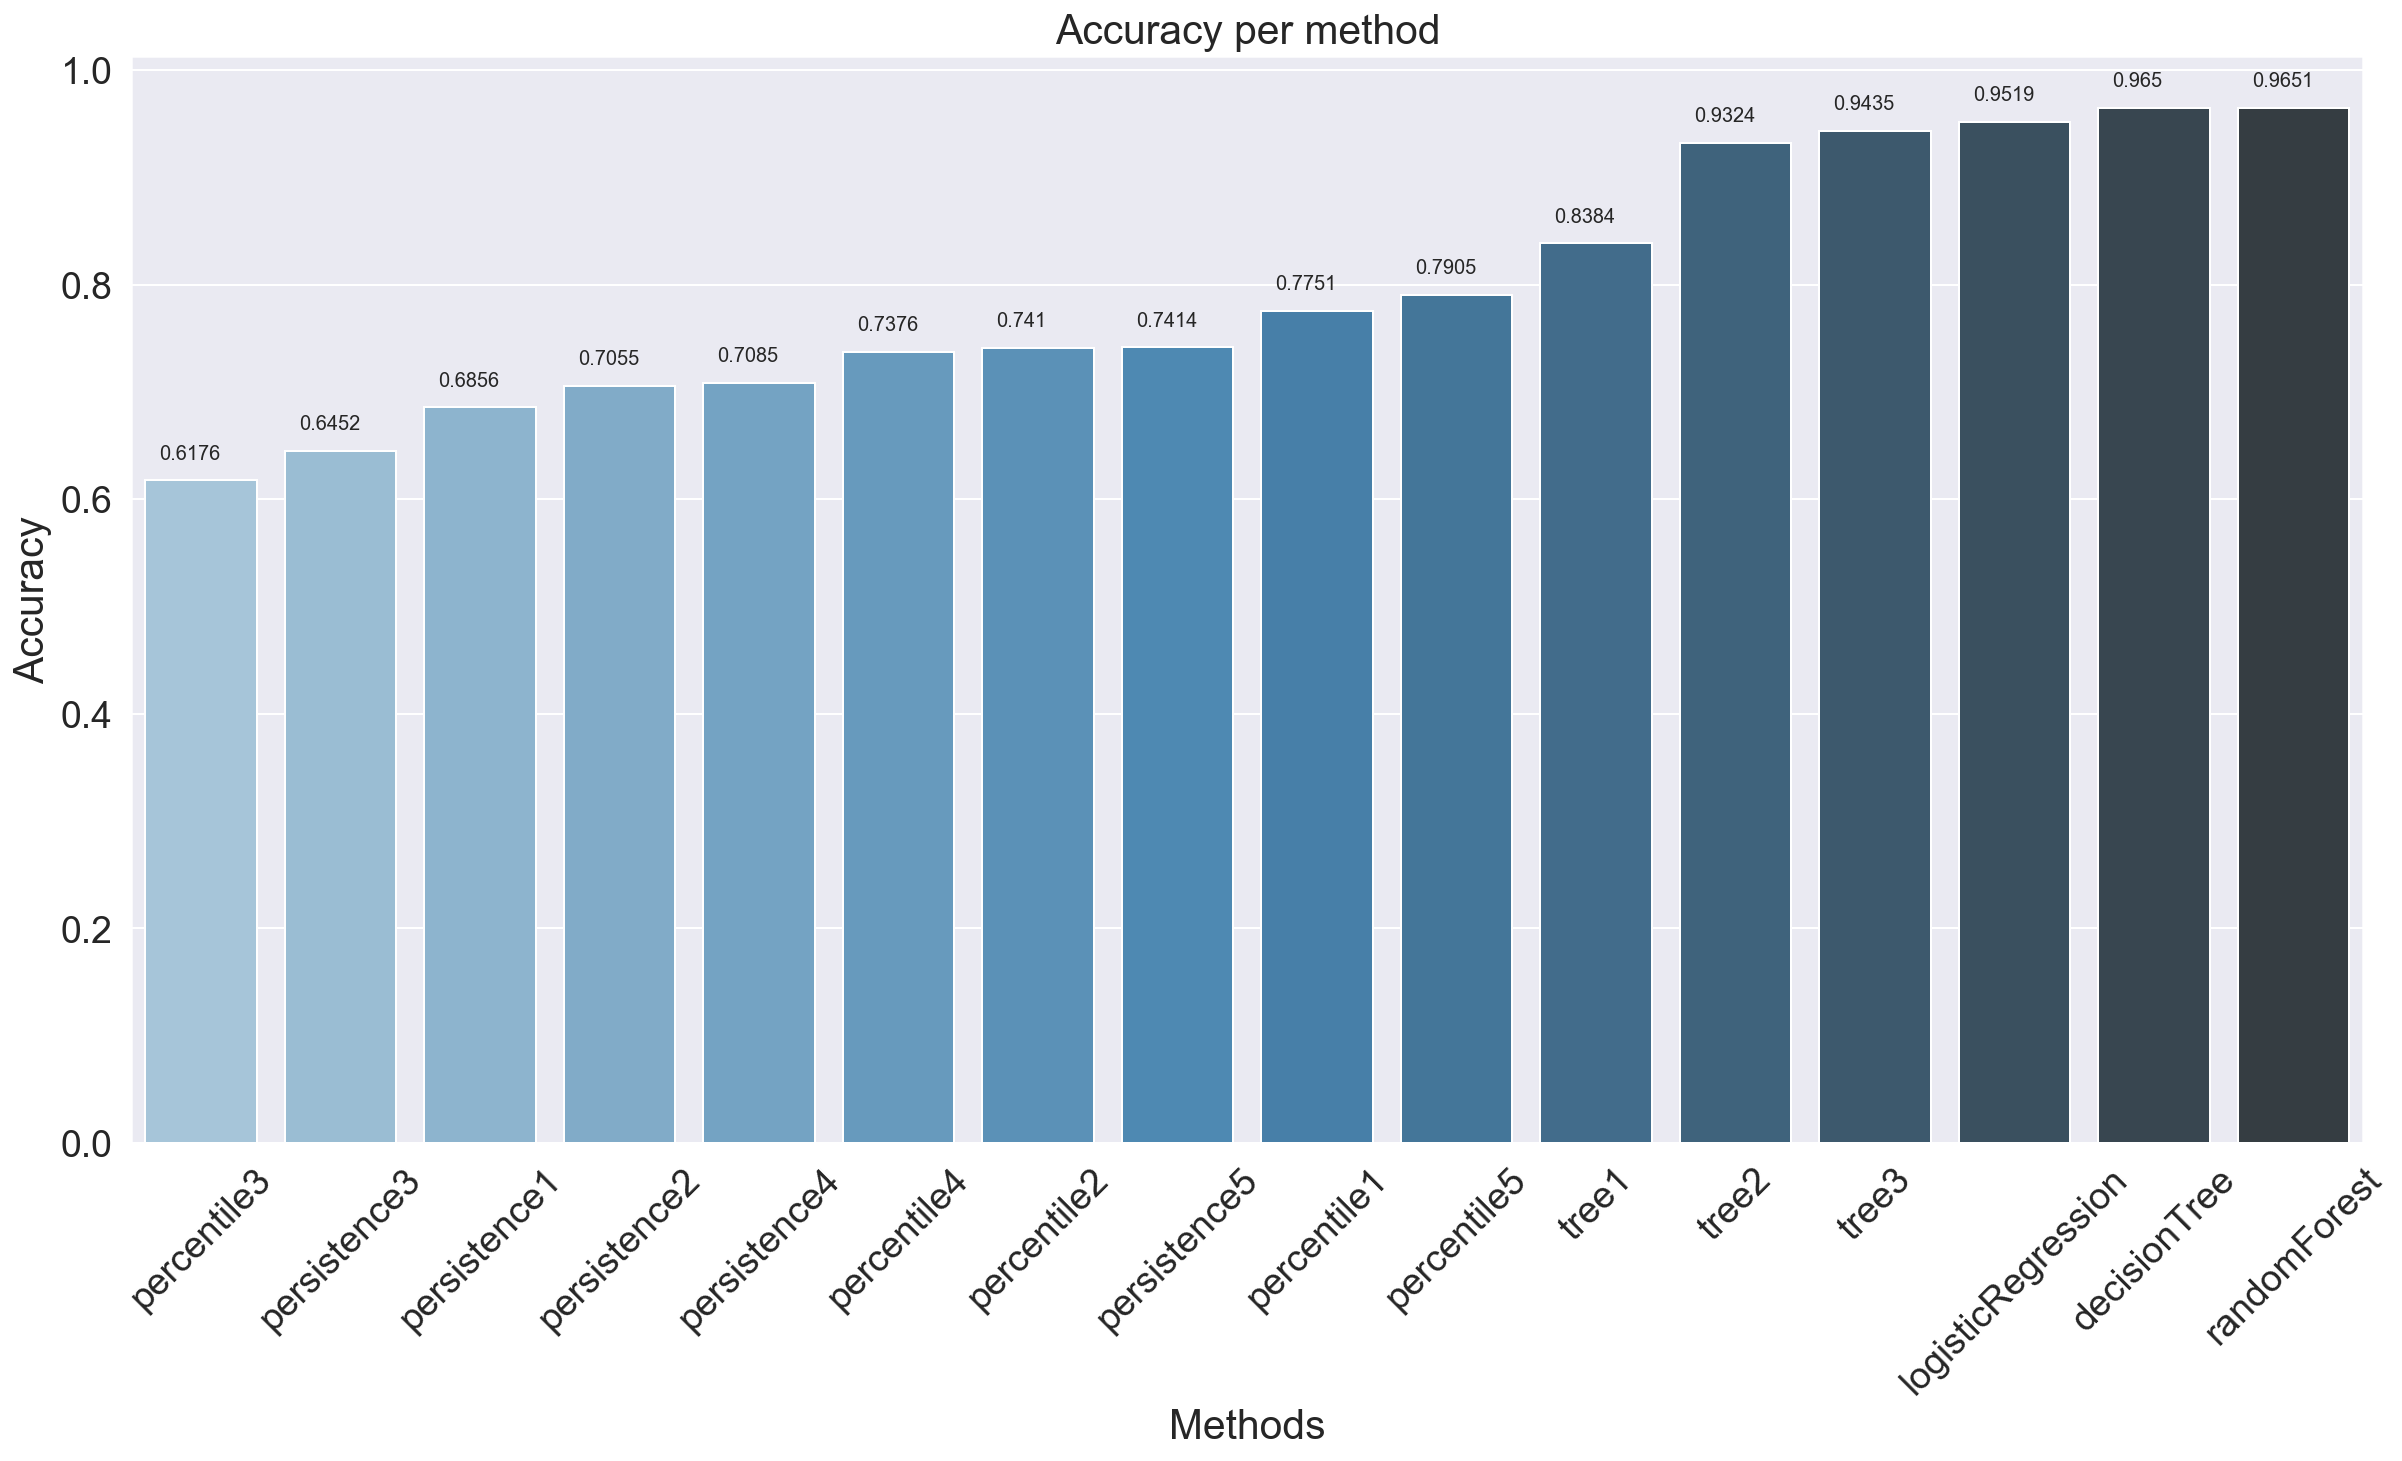

,Methods,Accuracy
3,percentile1,0.775145
4,percentile2,0.740978
5,percentile3,0.617571
6,percentile4,0.737553
7,percentile5,0.790466
8,persistence1,0.685592
9,persistence2,0.705503
10,persistence3,0.645212
11,persistence4,0.708464
12,persistence5,0.741443


In [14]:
plot_accuracy_over_methods(res_accuracy)
res_accuracy